In [3]:
import torch
import torch.nn as nn
import time
import numpy as np
import pandas as pd
from tqdm import tqdm
import chess
from nnue import HIDDEN_SIZE, INPUT_SIZE, EVAL_SCALE, fen_to_onehot, NNUE
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
df = pd.read_csv("./train.csv")

In [5]:
df['short fen'] = df['FEN'].map(lambda s : s.split(" ")[0])
df['score'] = df['Evaluation'].map(lambda x : 0.5 + min(1000, max(-1000, x)) / 2000)

In [6]:
df.head(10)

,FEN,Evaluation,short fen,score
0,r1b2rk1/ppp2pbp/3q1np1/n3p1B1/2B5/1Q3N2/PP1N1P...,-135,r1b2rk1/ppp2pbp/3q1np1/n3p1B1/2B5/1Q3N2/PP1N1P...,0.4325
1,8/1pp2p2/6k1/4P2p/p1PR1K1P/2r2P2/6P1/8 w - - 0 33,-57,8/1pp2p2/6k1/4P2p/p1PR1K1P/2r2P2/6P1/8,0.4715
2,r2qk1nr/1b3pbp/n3p1p1/1pp1P3/p2PN3/2P2N2/PPB3P...,541,r2qk1nr/1b3pbp/n3p1p1/1pp1P3/p2PN3/2P2N2/PPB3P...,0.7705
3,2b2rk1/5pp1/p2q1n1p/P2pn3/3N4/3BP1B1/2Q2PPP/Rr...,163,2b2rk1/5pp1/p2q1n1p/P2pn3/3N4/3BP1B1/2Q2PPP/Rr4K1,0.5815
4,r2qkb1r/ppp2ppb/2n1p3/3n2PQ/3Pp3/2P4P/PP6/RNB1...,-332,r2qkb1r/ppp2ppb/2n1p3/3n2PQ/3Pp3/2P4P/PP6/RNB1...,0.3340
5,r1bq1rk1/ppp2ppp/3p4/2b1p1NP/2Bnn3/4Q3/PPPP1PP...,-1167,r1bq1rk1/ppp2ppp/3p4/2b1p1NP/2Bnn3/4Q3/PPPP1PP...,0.0000
6,4B3/5p1k/pp3pnp/4pN2/PP2b3/7P/5PP1/6K1 w - - 0 30,7,4B3/5p1k/pp3pnp/4pN2/PP2b3/7P/5PP1/6K1,0.5035
7,r1b1k2r/ppp2p2/2nqpn1p/3p2p1/3P4/P1P1PN1P/1P1N...,85,r1b1k2r/ppp2p2/2nqpn1p/3p2p1/3P4/P1P1PN1P/1P1N...,0.5425
8,8/R2n4/4k2p/P5p1/4P3/1K3P2/6Pb/8 w - - 1 32,379,8/R2n4/4k2p/P5p1/4P3/1K3P2/6Pb/8,0.6895
9,r1b2b1r/pp2q1pk/2p3p1/3p2p1/4P2P/1Q4P1/PPPN1PB...,850,r1b2b1r/pp2q1pk/2p3p1/3p2p1/4P2P/1Q4P1/PPPN1PB...,0.9250


In [7]:
BATCH_SIZE = 256
testing_df = df.sample(frac=0.01)
training_df = df.drop(testing_df.index)
train_dataset = np.array_split(training_df[['short fen', 'score']], int(len(training_df) / BATCH_SIZE))
test_dataset = np.array_split(testing_df[['short fen', 'score']], int(len(testing_df) / BATCH_SIZE))

c:\Users\monte\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)
c:\Users\monte\AppData\Local\Programs\Python\Python312\Lib\site-packages\numpy\_core\fromnumeric.py:57: FutureWarning: 'DataFrame.swapaxes' is deprecated and will be removed in a future version. Please use 'DataFrame.transpose' instead.
  return bound(*args, **kwds)


In [8]:
len(train_dataset), len(test_dataset)

(7654, 77)

In [9]:
class TrainingNNUE(nn.Module):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.l1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZE, bias=True)
        self.l2 = nn.Linear(2 * HIDDEN_SIZE, 1, bias = True)

    def forward(self, x):
        x = self.l1(x)      # (B, H)
        x = torch.concat((x, -x), dim=-1)   # (B, 2*H)
        x = torch.square(torch.clip(x, 0, 1))
        x = self.l2(x)
        return torch.sigmoid(x)


In [11]:
model = TrainingNNUE()
#model.load_state_dict(torch.load("./models/nnue1.ckpt", weights_only=True))
model.cuda()
total_losses = []
total_test_losses = []

In [ ]:
loss_func = nn.SmoothL1Loss()
optimizer = torch.optim.AdamW(model.parameters())

n_epochs = 1
for epoch in range(n_epochs):
    losses = []
    test_losses = []
    
    # Training epoch
    model.train()
    for batch in tqdm(train_dataset):
        batch_targets = torch.FloatTensor(batch['score'].values).cuda()
        batch_inputs = torch.FloatTensor(np.array([fen_to_onehot(f) for f in batch['short fen'].values])).cuda()

        outputs = model(batch_inputs)
        loss = loss_func(torch.flatten(outputs), batch_targets)

        loss_val = loss.cpu().detach().numpy()
        losses.append(loss_val)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Testing epoch
    model.eval()
    with torch.inference_mode():
        for batch in tqdm(test_dataset):
            batch_targets = torch.FloatTensor(batch['score'].values).cuda()
            batch_inputs = torch.FloatTensor(np.array([fen_to_onehot(f) for f in batch['short fen'].values])).cuda()

            outputs = model(batch_inputs)
            loss = loss_func(torch.flatten(outputs), batch_targets)

            loss_val = loss.cpu().detach().numpy()
            test_losses.append(loss_val)

    total_losses.append(np.mean(losses))
    total_test_losses.append(np.mean(test_losses))
    print('Epoch', epoch, '- train loss', np.mean(losses), '- test loss', np.mean(test_losses))

torch.save(model.state_dict(), "./models/nnue1.ckpt")

100%|██████████| 77/77 [00:02<00:00, 34.89it/s]


Epoch 0 - train loss 0.0049297153 - test loss 0.0041358573


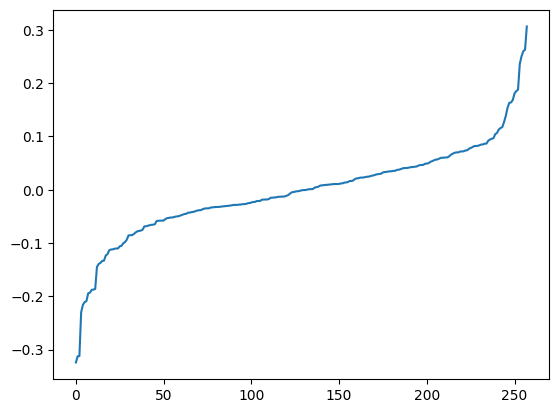

In [ ]:
with torch.inference_mode():
    batch = test_dataset[1]
    batch_targets = torch.FloatTensor(batch['score'].values).cuda()
    batch_inputs = torch.FloatTensor(np.array([fen_to_onehot(f) for f in batch['short fen'].values])).cuda()

    outputs = model(batch_inputs)
    l = list((torch.flatten(outputs) - batch_targets).cpu())
    l.sort()
    plt.plot(l)


In [17]:
model.eval()
model.cpu()
with torch.inference_mode():
    print(model(torch.FloatTensor(fen_to_onehot(chess.Board.starting_fen.split(" ")[0]))))

tensor([0.5142])
